# Linear regresion for counting

### Librarys

To read the images the function input_pipeline is going to create a pipeline where tensorflow can read images

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import tensorflow.contrib.keras as k

In [2]:
from sklearn import preprocessing

### Hyper parameters

In [3]:
N_EPOCHS = 10
BATCH_SIZE = 10
IMA_HEIGHT = 64
#IMA_WIDTH = int(round(IMA_HEIGHT*1.5,0))
IMA_WIDTH = 64
IMA_DEPTH = 3

In [4]:
def input_pipeline(paths,batch_size=2):
    file_names = tf.train.match_filenames_once(paths)
    filename_queues = tf.train.string_input_producer(file_names)
    
    reader = tf.WholeFileReader(name="reader")
    key, value = reader.read(filename_queues)
    image = tf.image.decode_jpeg(value)
    image = tf.image.resize_images(image,[IMA_HEIGHT,IMA_WIDTH],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image.set_shape((IMA_HEIGHT,IMA_WIDTH,IMA_DEPTH))
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    
    batch_size = batch_size
    num_process_threads = 2
    min_after_dequeue = 1
    
    labels , images = tf.train.shuffle_batch(
        [key,image],
        batch_size=batch_size,
        num_threads=num_process_threads,
        capacity= min_after_dequeue + (3)* batch_size,
        min_after_dequeue=min_after_dequeue,name="Batch"
    )
    return labels, images

In [5]:
def pixel_normalization(image,maxp=255,minp=0):
    return(image - minp)/(maxp - minp)

In [6]:
data = pd.read_csv("train.csv",index_col="train_id")
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(data)
text2Num = lambda label:np.array([data[int(str(text)[10:12])] for text in label],ndmin=2)

In [7]:
tf.reset_default_graph()
y_pipe, x_pipe = input_pipeline("./Train/*.jpg",BATCH_SIZE)

In [8]:
X = []
Y = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    try:
        for epoch in range(N_EPOCHS):
            batch_targets, batch_features = sess.run([y_pipe,x_pipe])
            batch_targets = text2Num(batch_targets)
            batch_features =  pixel_normalization(batch_features)
            
            X.append(batch_features)
            Y.append(batch_targets)
            
    except tf.errors.OutOfRangeError:
        print('Done Reading')
    finally:
        coord.request_stop()
    coord.join(threads)
X = np.vstack(X)
Y = np.vstack(Y)

array([  7.,   4.,  10.,   1.,   0.])

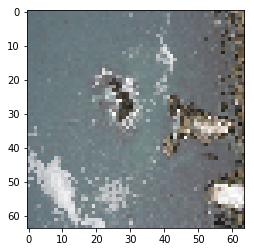

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X[99])
scaler.inverse_transform(Y)[99]

# Keras inplementation

In [10]:
tf.reset_default_graph()

In [11]:
img_shape = list(X.shape[1:])

In [12]:
inputs = k.layers.Input(shape=img_shape)

net = inputs
net = k.layers.Conv2D(9,3,activation=None)(net)
net = k.layers.MaxPool2D()(net)
net = k.layers.BatchNormalization()(net)
net = k.layers.Activation("relu")(net)

net = k.layers.Conv2D(3,2,activation=None)(net)
net = k.layers.MaxPool2D()(net)
net = k.layers.BatchNormalization()(net)
net = k.layers.Activation("relu")(net)

net = k.layers.Flatten()(net)

net = k.layers.Dense(500,activation="relu")(net)
net = k.layers.Dense(150,activation="relu")(net)
net = k.layers.Dropout(0.6)(net)

net = k.layers.Dense(5,activation="linear")(net)

outputs = net

In [13]:
model = k.models.Model(inputs,outputs)

In [14]:
model.compile(optimizer=k.optimizers.Adam(),loss=k.losses.mean_absolute_error)

In [15]:
model.fit(X,Y, epochs=10, batch_size=5,validation_split=0.3)

Train on 70 samples, validate on 30 samples
Epoch 1/10
70/70 [==============================] - 0s - loss: 1.1004 - val_loss: 0.6405
Epoch 2/10
70/70 [==============================] - 0s - loss: 0.7770 - val_loss: 0.6300
Epoch 3/10
70/70 [==============================] - 0s - loss: 0.6295 - val_loss: 0.6299
Epoch 4/10
70/70 [==============================] - 0s - loss: 0.5234 - val_loss: 0.6232
Epoch 5/10
70/70 [==============================] - 0s - loss: 0.4710 - val_loss: 0.6245
Epoch 6/10
70/70 [==============================] - 0s - loss: 0.4657 - val_loss: 0.6100
Epoch 7/10
70/70 [==============================] - 0s - loss: 0.4298 - val_loss: 0.6008
Epoch 8/10
70/70 [==============================] - 0s - loss: 0.4506 - val_loss: 0.5992
Epoch 9/10
70/70 [==============================] - 0s - loss: 0.4312 - val_loss: 0.6036
Epoch 10/10
70/70 [==============================] - 0s - loss: 0.3991 - val_loss: 0.5943


In [17]:
np.round(scaler.inverse_transform(model.predict(X[:10])))

array([[  5.,   4.,  35.,  19.,  13.],
       [  4.,   3.,  25.,  13.,   9.],
       [  4.,   3.,  26.,  13.,  11.],
       [  6.,   5.,  43.,  19.,  18.],
       [  5.,   4.,  36.,  17.,  13.],
       [  5.,   4.,  34.,  17.,  13.],
       [  3.,   3.,  27.,  14.,   8.],
       [  5.,   4.,  34.,  17.,  14.],
       [  4.,   3.,  32.,  16.,  10.],
       [  6.,   3.,  40.,  17.,  19.]], dtype=float32)

In [18]:
np.round(scaler.inverse_transform(Y[:10]))

array([[   1.,    4.,    0.,    0.,    0.],
       [   7.,    4.,   10.,    1.,    0.],
       [   1.,    0.,    0.,    0.,    0.],
       [  13.,   16.,   48.,    3.,   33.],
       [   3.,    2.,   25.,   15.,    0.],
       [   4.,    7.,  100.,   27.,    0.],
       [   0.,    0.,    4.,   15.,    0.],
       [  15.,    0.,   85.,   18.,   59.],
       [   5.,   10.,   66.,   24.,    0.],
       [  28.,    4.,  338.,   47.,  189.]])

In [19]:
model.fit(X,Y, epochs=50, batch_size=5,validation_split=0.3)

Train on 70 samples, validate on 30 samples
Epoch 1/50
70/70 [==============================] - 0s - loss: 0.4058 - val_loss: 0.5917
Epoch 2/50
70/70 [==============================] - 0s - loss: 0.4057 - val_loss: 0.5838
Epoch 3/50
70/70 [==============================] - 0s - loss: 0.4148 - val_loss: 0.5721
Epoch 4/50
70/70 [==============================] - 0s - loss: 0.3570 - val_loss: 0.5430
Epoch 5/50
70/70 [==============================] - 0s - loss: 0.3739 - val_loss: 0.5396
Epoch 6/50
70/70 [==============================] - 0s - loss: 0.3704 - val_loss: 0.5497
Epoch 7/50
70/70 [==============================] - 0s - loss: 0.3981 - val_loss: 0.5263
Epoch 8/50
70/70 [==============================] - 0s - loss: 0.3629 - val_loss: 0.4919
Epoch 9/50
70/70 [==============================] - 0s - loss: 0.3841 - val_loss: 0.5291
Epoch 10/50
70/70 [==============================] - 0s - loss: 0.3511 - val_loss: 0.4915
Epoch 11/50
70/70 [==============================] - 0s - loss: 0

In [20]:
np.round(scaler.inverse_transform(model.predict(X[:10])))

array([[   1.,    4.,    5.,    4.,    1.],
       [   6.,    4.,   24.,    9.,    4.],
       [   4.,    2.,   25.,   12.,    6.],
       [  16.,   22.,   51.,   -5.,   49.],
       [   4.,    3.,   33.,   15.,    3.],
       [   5.,    7.,   81.,   23.,    4.],
       [   2.,    2.,   16.,   13.,    6.],
       [  19.,    0.,  124.,   21.,   91.],
       [   6.,   10.,   67.,   21.,    2.],
       [  23.,    4.,  289.,   39.,  155.]], dtype=float32)

In [21]:
np.round(scaler.inverse_transform(Y[:10]))

array([[   1.,    4.,    0.,    0.,    0.],
       [   7.,    4.,   10.,    1.,    0.],
       [   1.,    0.,    0.,    0.,    0.],
       [  13.,   16.,   48.,    3.,   33.],
       [   3.,    2.,   25.,   15.,    0.],
       [   4.,    7.,  100.,   27.,    0.],
       [   0.,    0.,    4.,   15.,    0.],
       [  15.,    0.,   85.,   18.,   59.],
       [   5.,   10.,   66.,   24.,    0.],
       [  28.,    4.,  338.,   47.,  189.]])

In [22]:
model.fit(X,Y, epochs=250, batch_size=5,validation_split=0.3)

Train on 70 samples, validate on 30 samples
Epoch 1/250
70/70 [==============================] - 0s - loss: 0.3287 - val_loss: 0.2900
Epoch 2/250
70/70 [==============================] - 0s - loss: 0.2979 - val_loss: 0.2661
Epoch 3/250
70/70 [==============================] - 0s - loss: 0.2532 - val_loss: 0.1893
Epoch 4/250
70/70 [==============================] - 0s - loss: 0.3035 - val_loss: 0.2055
Epoch 5/250
70/70 [==============================] - 0s - loss: 0.2339 - val_loss: 0.2407
Epoch 6/250
70/70 [==============================] - 0s - loss: 0.2994 - val_loss: 0.2268
Epoch 7/250
70/70 [==============================] - 0s - loss: 0.2332 - val_loss: 0.2139
Epoch 8/250
70/70 [==============================] - 0s - loss: 0.2736 - val_loss: 0.2033
Epoch 9/250
70/70 [==============================] - 0s - loss: 0.2714 - val_loss: 0.2783
Epoch 10/250
70/70 [==============================] - 0s - loss: 0.2463 - val_loss: 0.2537
Epoch 11/250
70/70 [==============================] - 0

70/70 [==============================] - 0s - loss: 0.2406 - val_loss: 0.1720
Epoch 91/250
70/70 [==============================] - 0s - loss: 0.2205 - val_loss: 0.2555
Epoch 92/250
70/70 [==============================] - 0s - loss: 0.2226 - val_loss: 0.1971
Epoch 93/250
70/70 [==============================] - 0s - loss: 0.2187 - val_loss: 0.2262
Epoch 94/250
70/70 [==============================] - 0s - loss: 0.2115 - val_loss: 0.2859
Epoch 95/250
70/70 [==============================] - 0s - loss: 0.2274 - val_loss: 0.2280
Epoch 96/250
70/70 [==============================] - 0s - loss: 0.2207 - val_loss: 0.2857
Epoch 97/250
70/70 [==============================] - 0s - loss: 0.2395 - val_loss: 0.1813
Epoch 98/250
70/70 [==============================] - 0s - loss: 0.3000 - val_loss: 0.2128
Epoch 99/250
70/70 [==============================] - 0s - loss: 0.1739 - val_loss: 0.2032
Epoch 100/250
70/70 [==============================] - 0s - loss: 0.2524 - val_loss: 0.1673
Epoch 101/2

70/70 [==============================] - 0s - loss: 0.1888 - val_loss: 0.1889
Epoch 180/250
70/70 [==============================] - 0s - loss: 0.1818 - val_loss: 0.1873
Epoch 181/250
70/70 [==============================] - 0s - loss: 0.2240 - val_loss: 0.1823
Epoch 182/250
70/70 [==============================] - 0s - loss: 0.2028 - val_loss: 0.2209
Epoch 183/250
70/70 [==============================] - 0s - loss: 0.2198 - val_loss: 0.1867
Epoch 184/250
70/70 [==============================] - 0s - loss: 0.1911 - val_loss: 0.1964
Epoch 185/250
70/70 [==============================] - 0s - loss: 0.1892 - val_loss: 0.2903
Epoch 186/250
70/70 [==============================] - 0s - loss: 0.1812 - val_loss: 0.2553
Epoch 187/250
70/70 [==============================] - 0s - loss: 0.1713 - val_loss: 0.2018
Epoch 188/250
70/70 [==============================] - 0s - loss: 0.1648 - val_loss: 0.2336
Epoch 189/250
70/70 [==============================] - 0s - loss: 0.2070 - val_loss: 0.2341
Ep

In [23]:
np.round(scaler.inverse_transform(model.predict(X[:10])))

array([[   2.,    4.,    7.,    3.,    0.],
       [   6.,    4.,   19.,    6.,    0.],
       [   2.,    1.,    5.,    5.,   -0.],
       [  12.,   14.,   50.,    6.,   31.],
       [   3.,    2.,   24.,   15.,   -0.],
       [   4.,    6.,   69.,   22.,    0.],
       [   0.,    0.,    6.,   15.,    0.],
       [  14.,    0.,   86.,   18.,   58.],
       [   5.,    9.,   58.,   21.,   -0.],
       [  27.,    4.,  321.,   46.,  182.]], dtype=float32)

In [24]:
np.round(scaler.inverse_transform(Y[:10]))

array([[   1.,    4.,    0.,    0.,    0.],
       [   7.,    4.,   10.,    1.,    0.],
       [   1.,    0.,    0.,    0.,    0.],
       [  13.,   16.,   48.,    3.,   33.],
       [   3.,    2.,   25.,   15.,    0.],
       [   4.,    7.,  100.,   27.,    0.],
       [   0.,    0.,    4.,   15.,    0.],
       [  15.,    0.,   85.,   18.,   59.],
       [   5.,   10.,   66.,   24.,    0.],
       [  28.,    4.,  338.,   47.,  189.]])